# Importing the dependencies

In [4]:
# Importing the dependencies
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.models import load_model
from keras import Sequential,layers
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
# import cv2
import zipfile
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os
print("Everything imported successfully !")

Everything imported successfully !


In [5]:
# To enable numpy operations on the tensor
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

ZIP archives are automatically accessible in Kaggle Kernels so you can just access your files as if they were already unzipped.. Also when working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

**Personal Note**: A ZIP archive is a container for compressed files or directories, and an individual ZIP file is a standalone compressed archive. 

In [7]:
# Variable to keep track of number of corrupt images and images deleted
num_skipped = 0

for folder_name in ("Potato___Early_blight", "Potato___Late_blight","Potato___healthy"):

    # Path of all the above mentioned directories
    folder_path = os.path.join("Dataset",folder_name)

    # Iterating through each and every file(image) in the respective directory
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # Constructing path to each of the file
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # Checking if JFIF string is present
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

# Let's see how many corrupt images are there
print("Deleted %d images" % num_skipped)

NotADirectoryError: [Errno 20] Not a directory: 'Dataset_zip.zip/Potato___Early_blight'

# Creating input pipeline for data loading

In [4]:
# Let's create tensorflow input pipeline
with tf.device('/cpu:0'):

    # Training data
    ds = tf.keras.utils.image_dataset_from_directory(
        directory="/kaggle/input/dataset-zip-folder/Dataset",
        batch_size=16,
        image_size=(256, 256),
        shuffle=True,
        validation_split=None,
        seed=123
    )

Found 2152 files belonging to 3 classes.


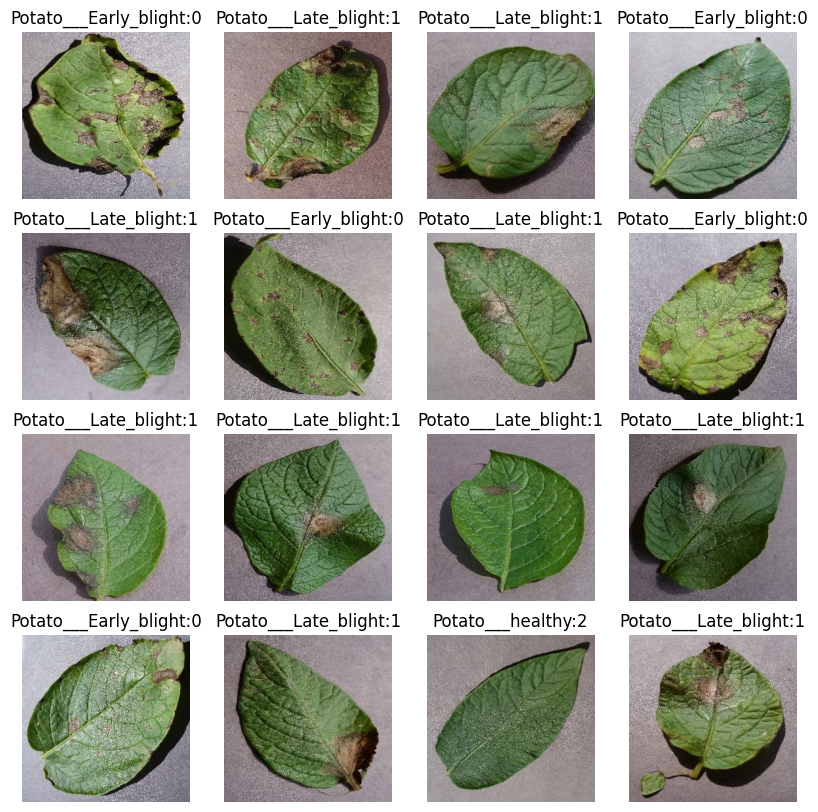

In [5]:
# Extracting the class names for assignign title names to images
class_names = ds.class_names

# Fetch a batch of images and labels from the dataset
for images, labels in ds.take(1):
    
    # Create a 4x4 grid of subplots
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(class_names[labels[i].numpy()]) + ":" + str(labels[i].numpy()))
        plt.axis("off")

    plt.show()

In [6]:
print("Total Batches : ",len(ds))
print("Total Training Batches (80:20) : ",len(ds)*0.8)
print("Total Testing Batches : ",len(ds)*0.2)

Total Batches :  135
Total Training Batches (80:20) :  108.0
Total Testing Batches :  27.0


In [7]:
def create_train_test_val(ds,train_size,val_size):
    
    # Calculating total batches
    total_batches = len(ds)
    
    # Extracting training,testing and validation batch from the dataset (ds)
    train_ds_batches = int(train_size*total_batches)
    val_ds_batches = int(val_size*total_batches)
    
    # 80:10:10
    train_ds = ds.take(train_ds_batches) 
    val_ds = ds.skip(train_ds_batches).take(val_ds_batches)
    test_ds = ds.skip(train_ds_batches).skip(val_ds_batches)
    
    # Catching and prefetching the dataset to improve data pipeline performance
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds,val_ds,test_ds


# Calling the function
train_ds,val_ds,test_ds = create_train_test_val(ds,0.8,0.1)

Since we know that Dataset pipelines are essential for machine learning. They are used to load, preprocess, and batch data before it is fed into a machine learning model.

The performance of a dataset pipeline can have a significant impact on the performance of a machine learning model. If a dataset pipeline is slow, it can bottleneck the overall performance of the model. `tfds.benchmark` is a simple and easy-to-use tool for evaluating the performance of dataset pipelines. It can be used to identify bottlenecks, compare different pipelines, and track progress over time.

In [8]:
# Display some benchmark statistics
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/108 [00:00<?, ?it/s]

Examples/sec (First included) 71.01 ex/sec (total: 109 ex, 1.54 sec)
Examples/sec (First only) 6.42 ex/sec (total: 1 ex, 0.16 sec)
Examples/sec (First excluded) 78.31 ex/sec (total: 108 ex, 1.38 sec)


BenchmarkResult(stats=             duration  num_examples        avg
first+lasts  1.535021           109  71.008797
first        0.155829             1   6.417298
lasts        1.379192           108  78.306703, raw_stats=                    duration
start_time        375.121198
first_batch_time  375.277027
end_time          376.656219
num_iter          108.000000)

# Processing the data

In [9]:
# Create the data augmentation model
data_augmentation_layer = Sequential([
    layers.RandomFlip(mode = "horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [10]:
for img,label in train_ds.take(1):
    print(label)

tf.Tensor([0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0], shape=(16,), dtype=int32)


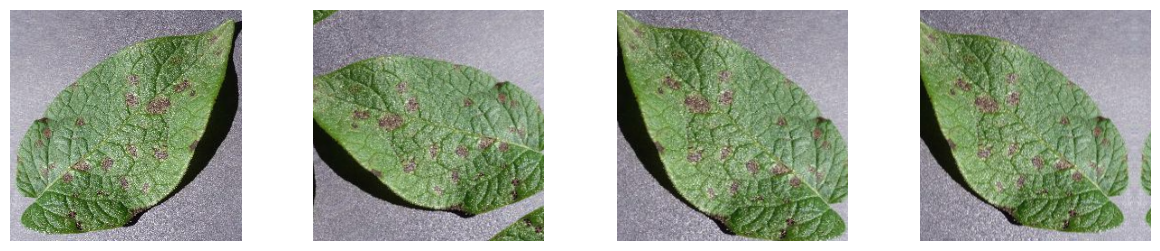

In [11]:
# Now just for testing let's take a single image and apply preprocessing on it
for img,labels in train_ds.take(1):
    single_img = img[0].numpy()
    break

# Apply data augmentation to the single image
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
for i, layer in enumerate(data_augmentation_layer.layers):
    augmented_image = layer(tf.expand_dims(single_img, axis=0), training=True)
    ax[i].imshow(augmented_image[0].numpy().astype("uint8"))
    ax[i].axis("off")

plt.show()

In [12]:
# Defining the layer for resizing and rescaling
Resize_Rescale_layer = Sequential([
  layers.Resizing(256, 256),
  layers.Rescaling(scale = 1./255),
])

# Model building ( Custom CNN )

In [13]:
input_shape = (16, 256, 256, 3)
n_classes = 3

model = Sequential([
    data_augmentation_layer,
    Resize_Rescale_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 64)          0         
 g2D)                                                 

In [14]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

- Number of epochs
- Using some pretrained architecture

In [15]:
# Training the model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history_custon_cnn = model.fit(train_ds,
                     epochs=num_epochs, 
                     validation_data=val_ds,
                     callbacks =[early_stop],
                     verbose=1)

Epoch 1/30
108/108 [==============================] - 22s 44ms/step - loss: 0.8659 - accuracy: 0.5214 - val_loss: 0.7657 - val_accuracy: 0.6058
Epoch 2/30
108/108 [==============================] - 3s 31ms/step - loss: 0.6461 - accuracy: 0.7251 - val_loss: 0.7900 - val_accuracy: 0.6154
Epoch 3/30
108/108 [==============================] - 3s 31ms/step - loss: 0.4808 - accuracy: 0.7940 - val_loss: 0.6222 - val_accuracy: 0.7788
Epoch 4/30
108/108 [==============================] - 3s 31ms/step - loss: 0.4322 - accuracy: 0.8310 - val_loss: 0.5238 - val_accuracy: 0.8173
Epoch 5/30
108/108 [==============================] - 3s 31ms/step - loss: 0.3780 - accuracy: 0.8495 - val_loss: 0.5541 - val_accuracy: 0.7740
Epoch 6/30
108/108 [==============================] - 3s 31ms/step - loss: 0.2991 - accuracy: 0.8733 - val_loss: 0.3633 - val_accuracy: 0.8462
Epoch 7/30
108/108 [==============================] - 3s 31ms/step - loss: 0.2863 - accuracy: 0.8756 - val_loss: 0.3689 - val_accuracy: 0.851

In [16]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)
print("Loss : ",loss)
print("Accuracy : ",accuracy)

13/13 [==============================] - 0s 11ms/step - loss: 0.1189 - accuracy: 0.9519
Loss :  0.11892794072628021
Accuracy :  0.9519230723381042


In [17]:
# Calculating the training and validation accuracy
acc = history_custon_cnn.history['accuracy']
val_acc = history_custon_cnn.history['val_accuracy']

loss = history_custon_cnn.history['loss']
val_loss = history_custon_cnn.history['val_loss']

In [18]:
# Function for visualizing the results
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

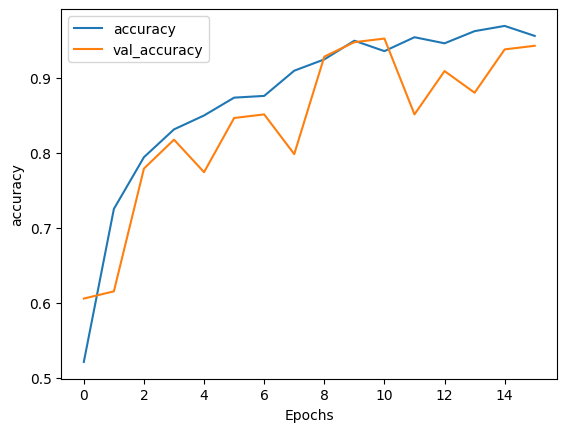

In [19]:
plot_graphs(history_custon_cnn,'accuracy')

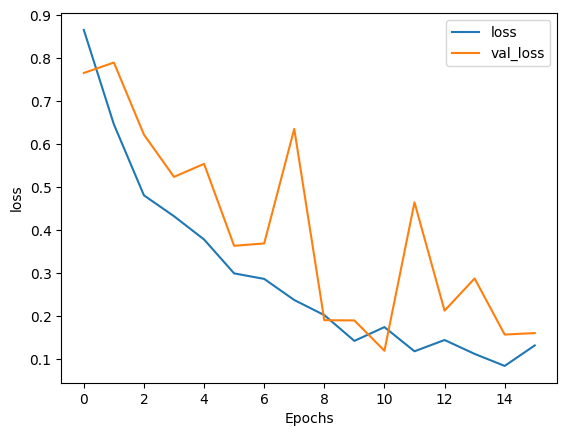

In [20]:
plot_graphs(history_custon_cnn,'loss')

In [21]:
# Saving the model
model.save("CustomModel.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Alexnet

In [22]:
# Defining the layer for resizing and rescaling for alexnet
Resize_Rescale_layer_alexnet = Sequential([
  layers.Resizing(227, 227),
  layers.Rescaling(scale = 1./255),
])

In [23]:
input_shape = (16, 227, 227, 3)
n_classes = 3

AL_NET_model = Sequential([
    data_augmentation_layer,
    Resize_Rescale_layer_alexnet,
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),    
    keras.layers.Dense(n_classes, activation='softmax')
])

AL_NET_model.build(input_shape=input_shape)
AL_NET_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 sequential_3 (Sequential)   (16, 227, 227, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (16, 55, 55, 96)          34944     
                                                                 
 batch_normalization (Batch  (16, 55, 55, 96)          384       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (16, 27, 27, 96)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (16, 27, 27, 256)        

In [24]:
# Compiling the model
AL_NET_model.compile(
    optimizer=tf.optimizers.SGD(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
# Training the model
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)
history_alexnet = AL_NET_model.fit(train_ds,
                     epochs=num_epochs, 
                     validation_data=val_ds,
                     callbacks =[early_stop],
                     verbose=1)

Epoch 1/50
108/108 [==============================] - 9s 41ms/step - loss: 1.8316 - accuracy: 0.7425 - val_loss: 0.9337 - val_accuracy: 0.6154
Epoch 2/50
108/108 [==============================] - 4s 34ms/step - loss: 0.6074 - accuracy: 0.8108 - val_loss: 2.9619 - val_accuracy: 0.5481
Epoch 3/50
108/108 [==============================] - 4s 37ms/step - loss: 0.4345 - accuracy: 0.8669 - val_loss: 0.5247 - val_accuracy: 0.8221
Epoch 4/50
108/108 [==============================] - 4s 34ms/step - loss: 0.3457 - accuracy: 0.8854 - val_loss: 1.8471 - val_accuracy: 0.6394
Epoch 5/50
108/108 [==============================] - 4s 37ms/step - loss: 0.3053 - accuracy: 0.9028 - val_loss: 0.4951 - val_accuracy: 0.8029
Epoch 6/50
108/108 [==============================] - 4s 37ms/step - loss: 0.2346 - accuracy: 0.9149 - val_loss: 0.3539 - val_accuracy: 0.8413
Epoch 7/50
108/108 [==============================] - 4s 35ms/step - loss: 0.1972 - accuracy: 0.9410 - val_loss: 0.8666 - val_accuracy: 0.7115

In [26]:
# Evaluate the model on the test dataset
loss, accuracy = AL_NET_model.evaluate(test_ds)
print("Loss : ",loss)
print("Accuracy : ",accuracy)

13/13 [==============================] - 0s 12ms/step - loss: 0.1641 - accuracy: 0.9471
Loss :  0.1640552431344986
Accuracy :  0.9471153616905212


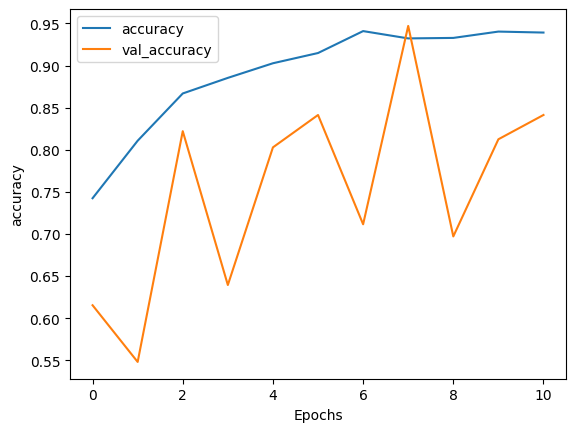

In [27]:
plot_graphs(history_alexnet,'accuracy')

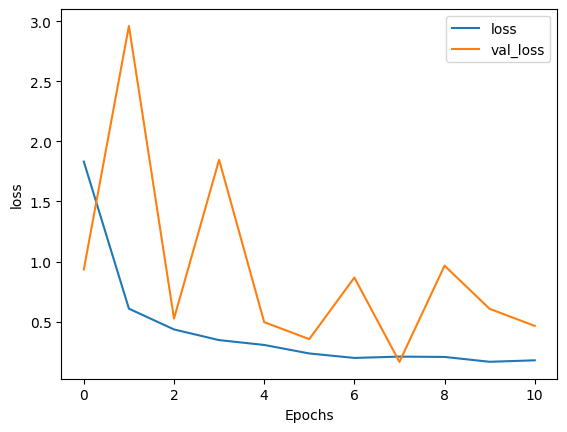

In [28]:
plot_graphs(history_alexnet,'loss')

In [29]:
# Saving the model
AL_NET_model.save("Alexnet.h5")

# VGG16 Model

In [30]:
# Defining the layer for resizing and rescaling for alexnet
Resize_Rescale_layer_vgg = Sequential([
  layers.Resizing(224, 224),
  layers.Rescaling(scale = 1./255),
])

In [31]:
# We will be using only feature extractor thus include_top = False
vgg16_model_fe = VGG16(weights='imagenet',include_top=False)
vgg16_model_fe.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [32]:
input_shape = (16, 224, 224, 3)
n_classes = 3

vgg16_model = Sequential([
    data_augmentation_layer,
    Resize_Rescale_layer_vgg,
    vgg16_model_fe,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

vgg16_model.build(input_shape=input_shape)
vgg16_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 sequential_5 (Sequential)   (16, 224, 224, 3)         0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (16, 25088)               0         
                                                                 
 dense_5 (Dense)             (16, 64)                  1605696   
                                                                 
 dense_6 (Dense)             (16, 3)                   195       
                                                                 
Total params: 16320579 (62.26 MB)
Trainable params: 16

In [33]:
# Compiling the model
vgg16_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history_vgg = vgg16_model.fit(train_ds,
                     epochs=num_epochs, 
                     validation_data=val_ds,
                     callbacks =[early_stop],
                     verbose=1)

Epoch 1/30
108/108 [==============================] - 36s 216ms/step - loss: 1.1339 - accuracy: 0.6325 - val_loss: 0.5608 - val_accuracy: 0.7308
Epoch 2/30
108/108 [==============================] - 23s 212ms/step - loss: 0.4958 - accuracy: 0.8264 - val_loss: 0.9257 - val_accuracy: 0.6250
Epoch 3/30
108/108 [==============================] - 23s 211ms/step - loss: 0.3839 - accuracy: 0.8628 - val_loss: 0.2240 - val_accuracy: 0.9279
Epoch 4/30
108/108 [==============================] - 23s 211ms/step - loss: 0.3583 - accuracy: 0.8623 - val_loss: 0.2305 - val_accuracy: 0.9231
Epoch 5/30
108/108 [==============================] - 23s 212ms/step - loss: 0.2311 - accuracy: 0.9126 - val_loss: 0.0962 - val_accuracy: 0.9663
Epoch 6/30
108/108 [==============================] - 23s 211ms/step - loss: 0.2325 - accuracy: 0.9126 - val_loss: 0.1114 - val_accuracy: 0.9760
Epoch 7/30
108/108 [==============================] - 23s 211ms/step - loss: 0.1863 - accuracy: 0.9253 - val_loss: 0.1071 - val_ac

In [34]:
# Evaluate the model on the test dataset
loss, accuracy = vgg16_model.evaluate(test_ds)
print("Loss : ",loss)
print("Accuracy : ",accuracy)

13/13 [==============================] - 1s 62ms/step - loss: 0.0962 - accuracy: 0.9663
Loss :  0.09617441147565842
Accuracy :  0.9663461446762085


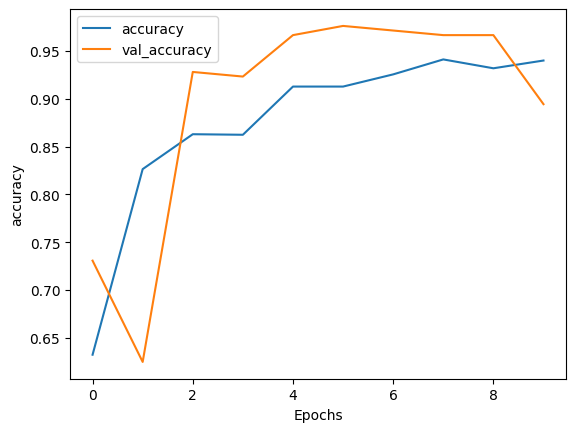

In [35]:
plot_graphs(history_vgg,'accuracy')

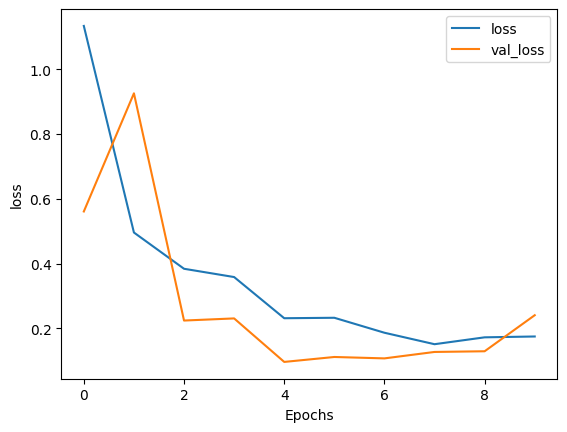

In [36]:
plot_graphs(history_vgg,'loss')

In [37]:
# Saving the trained model as .h5 file
vgg16_model.save("VGG16.h5")

# Saving the trained Model

In [38]:
# Saving the trained model as .h5 file
model.save("Model_Plain_CNN.h5")

# Model prediction

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 155ms/step
predicted label: Potato___Late_blight
first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 33ms/step
predicted label: Potato___Early_blight
first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 32ms/step
predicted label: Potato___Late_blight


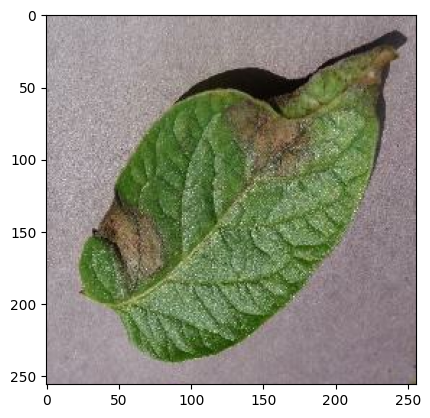

In [39]:
for images_batch, labels_batch in test_ds.take(3):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


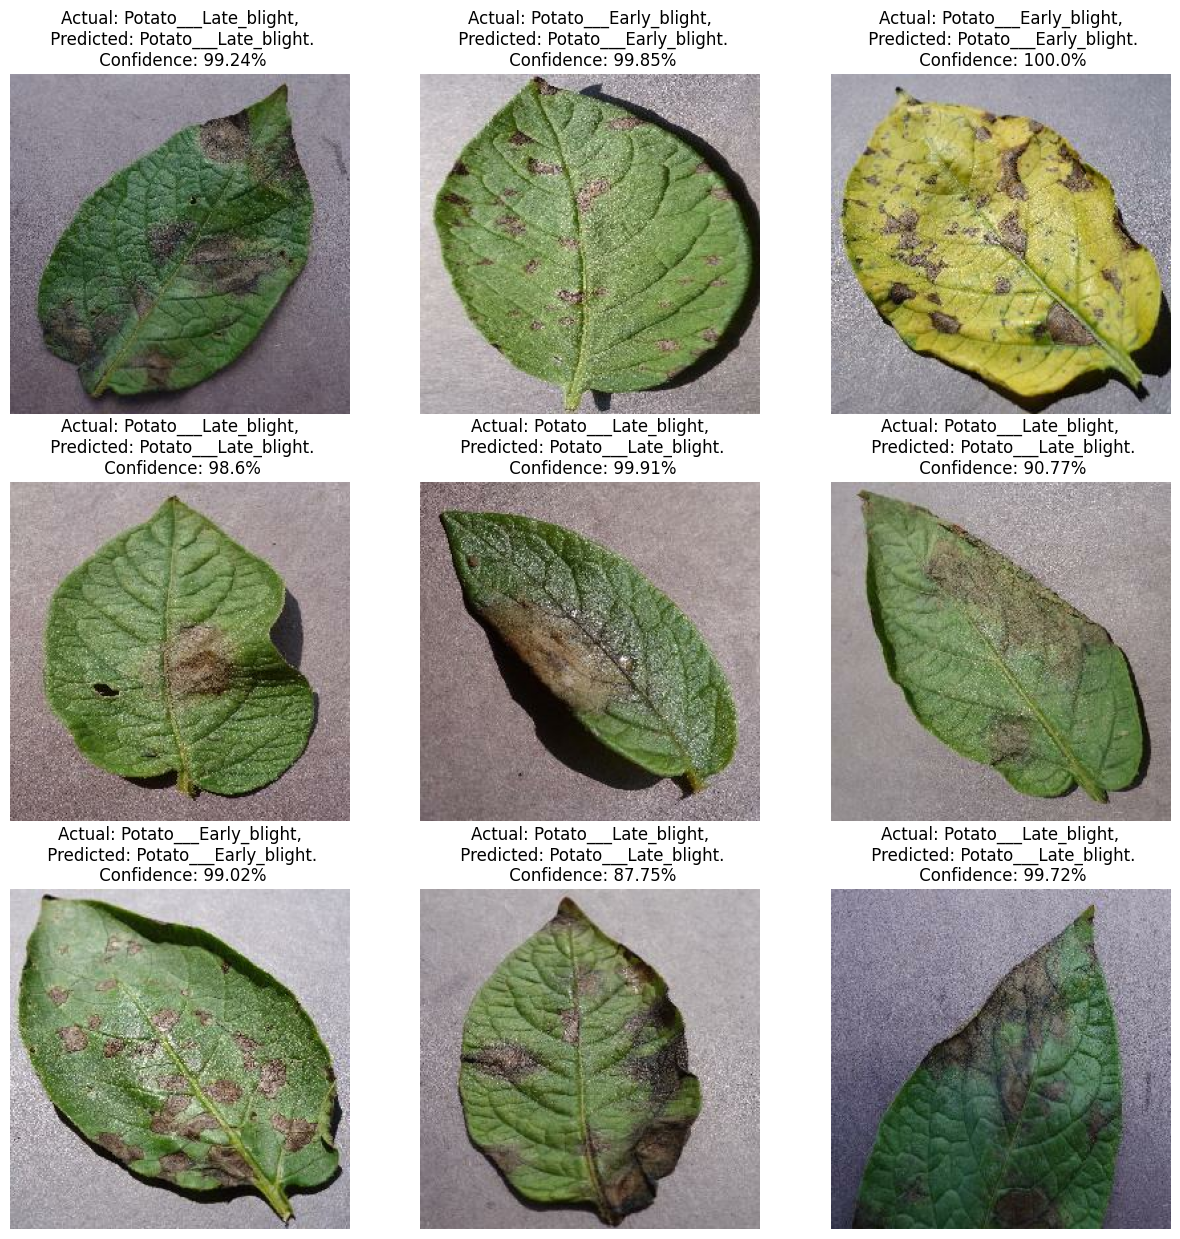

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")